In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import helper

## Analysis Questions

- What are the main factors that contribute to the pollution burden in Los Angeles?
- What are the less poluted areas in Los Angeles?
- What are the areas with lowest poverty?
- Is there a correlation between socioeconomic factors and pollution burden?
- How well can we predict the pollution burden?
- How well can we predict poverty?

## Prepare the data

The data provided by the Office of Environmental Health Hazard Assessment allows for identifying the effects of pollution in California communities. For the sake of this analysis, the focus will be around the Greater Los Angeles Area, which includes the counties of Los Angeles, Orange, San Bernardino, Riverside and Ventura. 

First let's get the data for the mentioned counties. 

In [3]:
file_loc = 'ces3results.csv'
la_county = ['Los Angeles', 'Orange ', 'San Bernardino', 'Riverside ', 'Ventura ']

In [4]:
df_la = helper.clean_data(file_loc, la_county, impute='mean')

In [5]:
df_la.head()

,census_tract,total_population,california_county,zip,nearby_city,longitude,latitude,ces_30_score,sb_535_disadvantaged_community,ozone,...,asthma,low_birth_weight,cardiovascular_disease,education,linguistic_isolation,poverty,unemployment,housing_burden,pop_char,pop_char_score
0,6071001600,6133,San Bernardino,91761,Ontario,-117.618013,34.057780,90.68,Yes,0.062,...,60.66,7.04,12.94,53.3,33.4,72.5,12.3,34.1,87.44,9.07
1,6037204920,2598,Los Angeles,90023,Los Angeles,-118.197498,34.017500,80.73,Yes,0.046,...,68.74,7.35,10.40,53.1,23.7,66.4,11.6,22.0,82.36,8.54
2,6037206050,2146,Los Angeles,90023,Los Angeles,-118.224453,34.029904,79.03,Yes,0.046,...,58.03,6.71,7.24,50.4,35.7,75.7,28.5,31.7,80.25,8.32
3,6037205120,3618,Los Angeles,90023,Los Angeles,-118.211796,34.018755,78.04,Yes,0.046,...,68.74,5.14,10.40,61.4,28.4,78.3,16.9,24.6,80.80,8.38
4,6037291220,3353,Los Angeles,90247,Gardena,-118.286709,33.877139,77.50,Yes,0.044,...,66.49,6.54,8.87,31.4,23.1,53.4,8.9,37.3,75.85,7.87


In [6]:
df_la.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3919 entries, 0 to 3918
Data columns (total 33 columns):
census_tract                      3919 non-null int64
total_population                  3919 non-null int64
california_county                 3919 non-null object
zip                               3919 non-null int64
nearby_city                       3919 non-null object
longitude                         3919 non-null float64
latitude                          3919 non-null float64
ces_30_score                      3919 non-null float64
sb_535_disadvantaged_community    3919 non-null object
ozone                             3919 non-null float64
pm25                              3919 non-null float64
diesel_pm                         3919 non-null float64
drinking_water                    3919 non-null float64
pesticides                        3919 non-null float64
tox_release                       3919 non-null float64
traffic                           3919 non-null float64
cleanup_sit

In [7]:
# Get a dataset with the dummy columns for the categorical ones
cat_cols = ['california_county', 'sb_535_disadvantaged_community']
df_la_cat = helper.handle_categorical(df_la, cat_cols)

In [8]:
df_la_cat.columns

Index(['census_tract', 'total_population', 'zip', 'nearby_city', 'longitude',
       'latitude', 'ces_30_score', 'ozone', 'pm25', 'diesel_pm',
       'drinking_water', 'pesticides', 'tox_release', 'traffic',
       'cleanup_sites', 'groundwater_threats', 'haz_waste', 'imp_water_bodies',
       'solid_waste', 'pollution_burden', 'pollution_burden_score', 'asthma',
       'low_birth_weight', 'cardiovascular_disease', 'education',
       'linguistic_isolation', 'poverty', 'unemployment', 'housing_burden',
       'pop_char', 'pop_char_score', 'california_county_Los Angeles',
       'california_county_Orange ', 'california_county_Riverside ',
       'california_county_San Bernardino', 'california_county_Ventura ',
       'sb_535_disadvantaged_community_No',
       'sb_535_disadvantaged_community_Yes'],
      dtype='object')

### Los Angeles general information

Let's start with few general infomation of the Greater Los Angeles Area. The total population is. 

In [9]:
total_pop = df_la.total_population.sum()
print(total_pop)

17876950


In [13]:
(df_la.groupby(['california_county', 'nearby_city']).sum().total_population/total_pop).sort_values(ascending=False).head(10)

california_county  nearby_city   
Los Angeles        Los Angeles       0.133845
                   Long Beach        0.026428
Riverside          Riverside         0.023831
Orange             Santa Ana         0.020238
                   Anaheim           0.018732
San Bernardino     San Bernardino    0.014941
Riverside          Corona            0.012485
Ventura            Oxnard            0.011804
San Bernardino     Fontana           0.011638
Orange             Irvine            0.011535
Name: total_population, dtype: float64

In [14]:
pop_split = df_la.groupby('california_county').sum().total_population/total_pop
num_zip = df_la.groupby('california_county').zip.nunique()

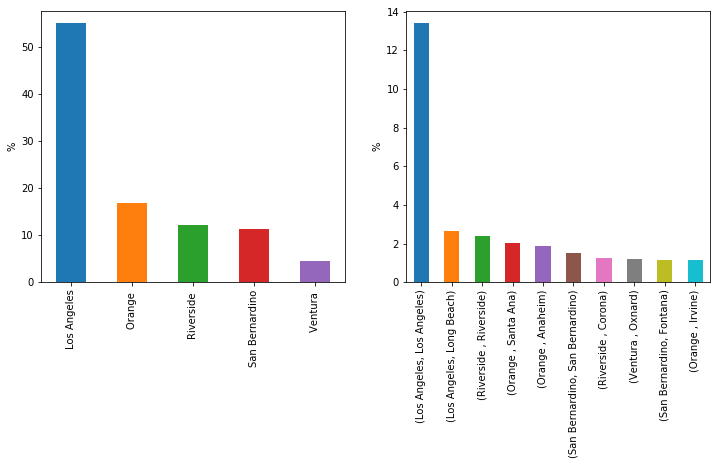

In [15]:
plt.subplot(121)
(100*pop_split).plot(kind='bar', figsize=(12,5));
plt.xlabel('');
plt.ylabel('%');
plt.subplot(122)
(100*df_la.groupby(['california_county', 'nearby_city']).sum().total_population/total_pop).sort_values(ascending=False).head(10).plot(kind='bar');
plt.xlabel('');
plt.ylabel('%');

In [16]:
pop_split

california_county
Los Angeles       0.549233
Orange            0.168386
Riverside         0.122484
San Bernardino    0.113845
Ventura           0.046052
Name: total_population, dtype: float64

In [17]:
num_zip

california_county
Los Angeles       282
Orange             87
Riverside          68
San Bernardino     67
Ventura            28
Name: zip, dtype: int64

We see that the total population is around 18 million. Almost 55% people and 282 of all ZIP codes are in Los Angeles county, 17% of people and 87 ZIP codes in Orange County, 12% of people and 68 ZIP codes in Riverside,  11% of people and 67 ZIP codes in San Bernardino, and 5% of people and 28 ZIP codes in the county of Ventura. 

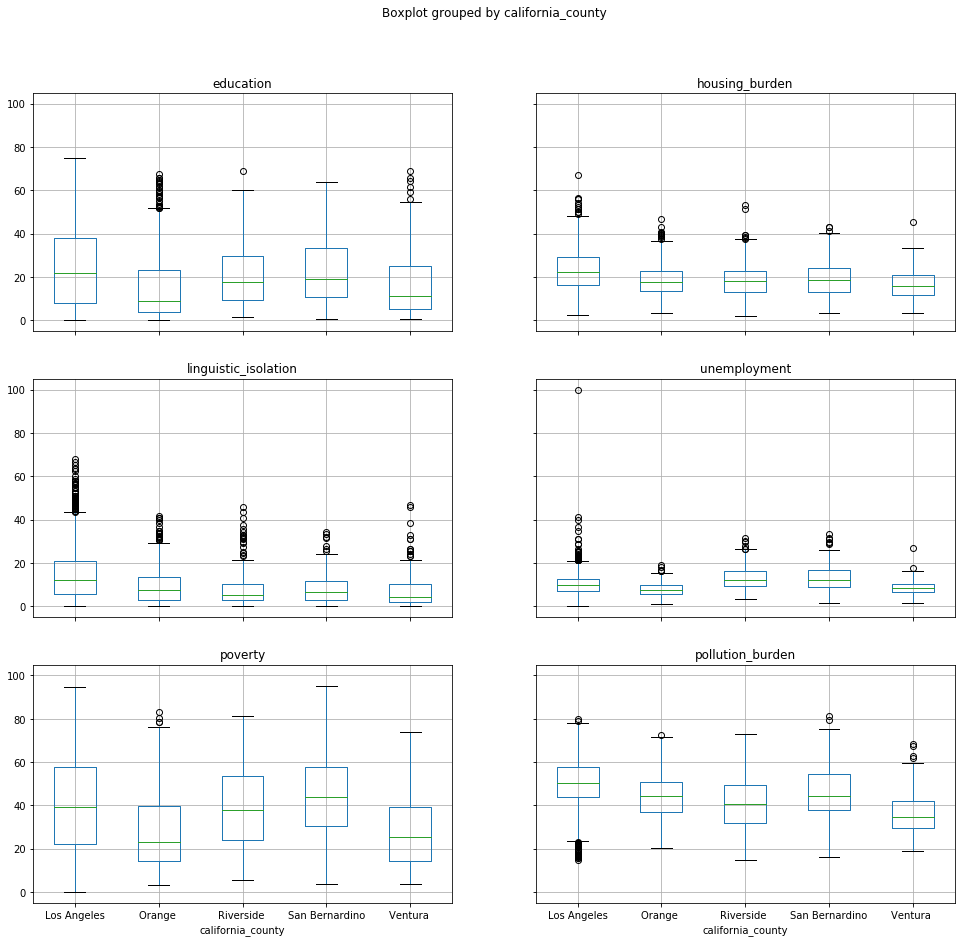

In [18]:
df_la.boxplot(column=['education','housing_burden','linguistic_isolation','unemployment', 'poverty', 'pollution_burden'], by='california_county',figsize=(16,15));

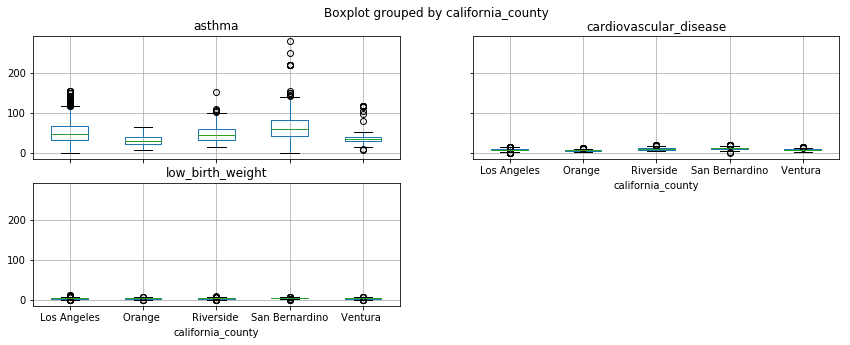

In [19]:
df_la.boxplot(column=['asthma', 'cardiovascular_disease', 'low_birth_weight'], by='california_county',figsize=(14,5));

Consistently, Orange county has the lowest socio-economic values when compared with the other counties. On the other hand, Los Angeles county scores the highest almost in every category. 

## Question 1 and 4

Let's determine the moderate and strong correlation values. This will help us determine what are the main factors affecting the pollution burden.

In [20]:
corr = df_la_cat.corr()

In [25]:
corr.pollution_burden[(corr.pollution_burden.abs() >= 0.3)]

census_tract                         -0.320060
zip                                  -0.396460
ces_30_score                          0.680900
pm25                                  0.630846
diesel_pm                             0.469542
traffic                               0.446796
cleanup_sites                         0.515450
groundwater_threats                   0.422746
haz_waste                             0.355236
solid_waste                           0.393173
pollution_burden                      1.000000
pollution_burden_score                0.999998
education                             0.314931
linguistic_isolation                  0.337100
california_county_Los Angeles         0.310406
sb_535_disadvantaged_community_No    -0.548386
sb_535_disadvantaged_community_Yes    0.548386
Name: pollution_burden, dtype: float64

Interestingly, the pollution burden has a moderate correlation with the Los Angeles county. In addition, it correlates to enviromental exposure factors such as diesel_pm, hazard waste and socio-economic factors such as education levels. 

In [22]:
corr.pollution_burden[corr.pollution_burden.abs() >= 0.5]

ces_30_score                          0.680900
pm25                                  0.630846
cleanup_sites                         0.515450
pollution_burden                      1.000000
pollution_burden_score                0.999998
sb_535_disadvantaged_community_No    -0.548386
sb_535_disadvantaged_community_Yes    0.548386
Name: pollution_burden, dtype: float64

The pollution burden strongly correlates with the pm2.5 factor that measures the quality of the air and the location of cleanup sites. Since the ces3.0 score is a measure of the pollution burden, and the status of a disadvantaged community it's determined by its pollution burden, it is expected this high correlation. 

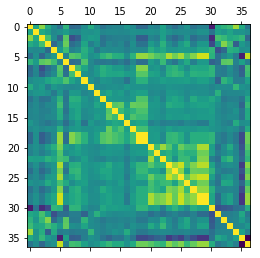

In [24]:
plt.matshow(corr)

## Question 2

Let's consider the 1% of data with the lowest values of pollution burden

In [27]:
df_la_low_burden = df_la[df_la.pollution_burden < df_la.pollution_burden.quantile(0.01)]

In [28]:
pop_low_burden = df_la_low_burden.total_population.sum()
print(pop_low_burden)

184308


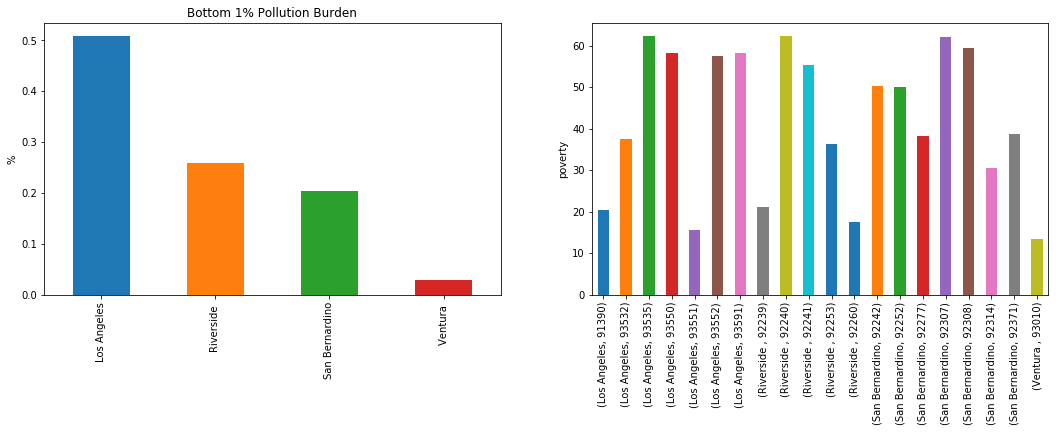

In [60]:

plt.subplot(121)
(df_la_low_burden.groupby('california_county').sum().total_population/pop_low_burden).plot(kind='Bar', figsize=(18,5))
plt.xlabel('');
plt.ylabel('%');
plt.title('Bottom 1% Pollution Burden');
plt.subplot(122)
df_la_low_burden.groupby(['california_county','zip']).mean().poverty.plot(kind='Bar');
plt.xlabel('');
plt.ylabel('poverty');

https://www.google.com/maps/d/embed?mid=1cdEoosv1ejLW9oLYWoUKG0tyxDzeEjh4

As it is seen in the map, all these areas are away from the main city. They are considered rural areas in the Greater Los Angeles Area. 

Let's consider the 1% of data with the highest values of pollution burden

In [35]:
df_la_high_burden = df_la[df_la.pollution_burden >= df_la.pollution_burden.quantile(0.99)]
pop_high_burden = df_la_high_burden.total_population.sum()
print(pop_high_burden)

147807


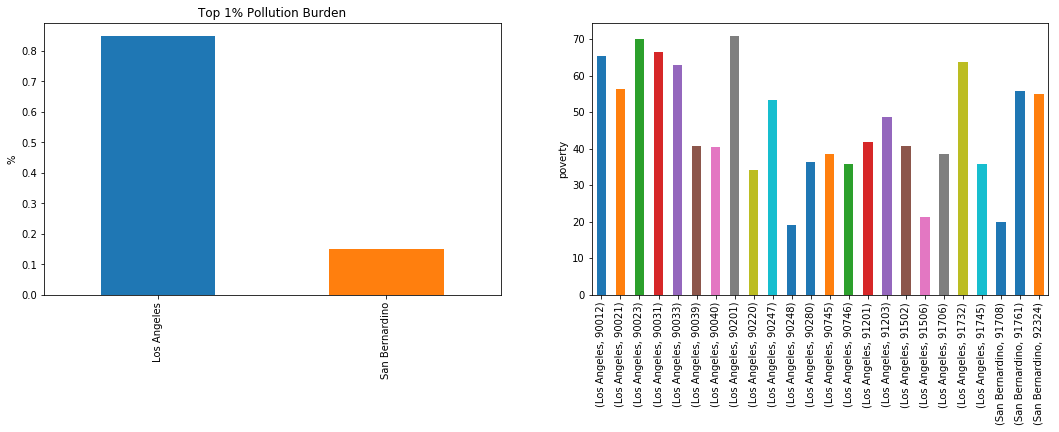

In [61]:
plt.subplot(121)
(df_la_high_burden.groupby('california_county').sum().total_population/pop_high_burden).plot(kind='Bar', figsize=(18,5));
plt.xlabel('');
plt.ylabel('%');
plt.title('Top 1% Pollution Burden');
plt.subplot(122)
(df_la_high_burden.groupby(['california_county','zip']).mean().poverty).plot(kind='Bar');
plt.xlabel('');
plt.ylabel('poverty');

As it is shown in the map, these areas are close to the city and generally close to industrial areas or main freeways. 

### Question 3

https://www.google.com/maps/d/u/0/embed?mid=1sGBKLO2L9zE1AKAor1Hq5Ik3Ogs1pykz&ll=34.22560668810106%2C-117.52577035000002&z=9

In [44]:
df_la_low_poverty = df_la[df_la.poverty < df_la.poverty.quantile(0.01)]
pop_low_poverty = df_la_low_poverty.total_population.sum()
print(pop_low_unemp)

143731


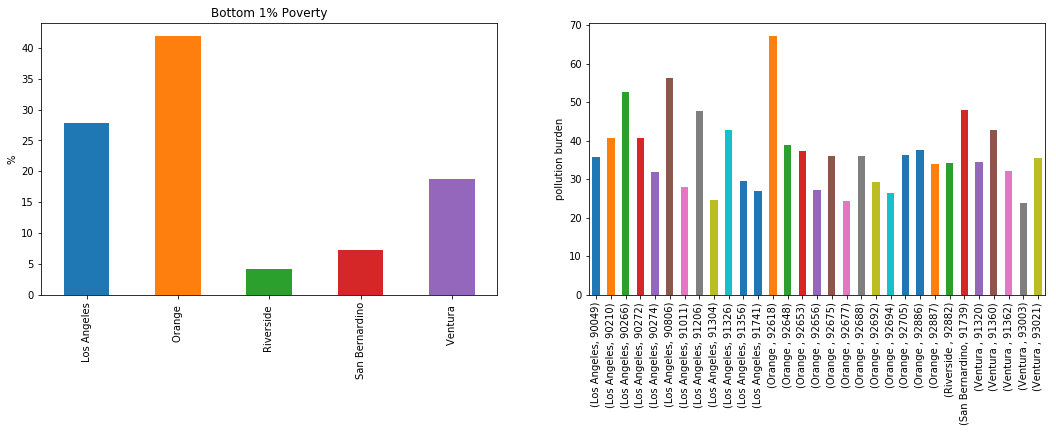

In [66]:
plt.subplot(121)
(100*df_la_low_poverty.groupby('california_county').sum().total_population/pop_low_poverty).plot(kind='Bar', figsize=(18,5));
plt.xlabel('');
plt.ylabel('%');
plt.title('Bottom 1% Poverty');
plt.subplot(122)
(df_la_low_poverty.groupby(['california_county','zip']).mean().pollution_burden).plot(kind='Bar');
plt.xlabel('');
plt.ylabel('pollution burden');

In the map, we observed that the lowest poverty is in areas that are considered affluent. Several of these areas are close to the ocean. 

In [46]:
df_la_high_poverty = df_la[df_la.poverty >= df_la.poverty.quantile(0.99)]
pop_high_poverty = df_la_high_poverty.total_population.sum()
print(pop_high_poverty)

142909


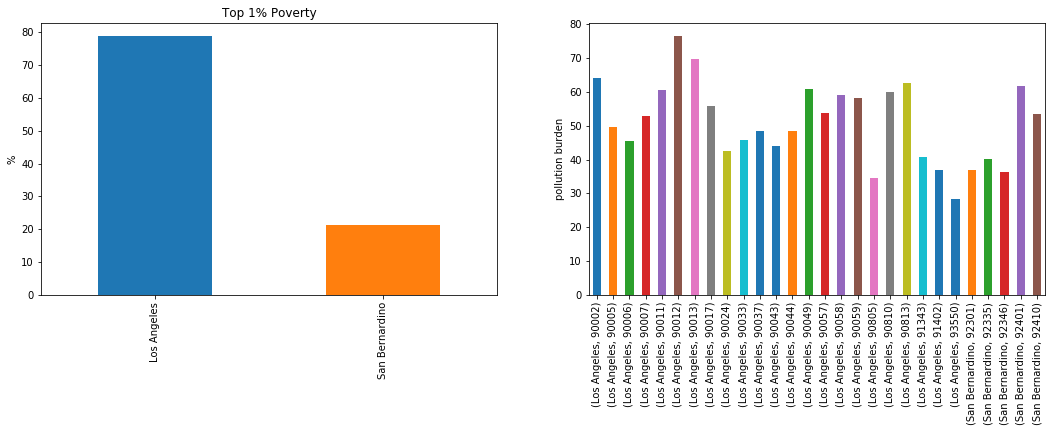

In [67]:
plt.subplot(121)
(100*df_la_high_poverty.groupby('california_county').sum().total_population/pop_high_poverty).plot(kind='Bar', figsize=(18,5));
plt.xlabel('');
plt.ylabel('%');
plt.title('Top 1% Poverty');
plt.subplot(122)
(df_la_high_poverty.groupby(['california_county','zip']).mean().pollution_burden).plot(kind='Bar');
plt.xlabel('');
plt.ylabel('pollution burden');

In the map we observe that these areas are a mixture of middle of the city and rural areas. 

### Question 5

In [27]:
response_col = 'pollution_burden'
test_size = 0.25
random_state = 10
columns = ['total_population', 'zip', 'longitude', 'latitude',
       'ces_30_score', 'ozone', 'pm25', 'diesel_pm', 'drinking_water',
       'pesticides', 'tox_release', 'traffic', 'cleanup_sites',
       'groundwater_threats', 'haz_waste', 'imp_water_bodies', 'solid_waste',
       'pollution_burden', 'asthma', 'low_birth_weight', 'cardiovascular_disease', 
       'education', 'linguistic_isolation', 'poverty', 'unemployment', 'housing_burden',
       'california_county_Los Angeles', 'california_county_Orange ', 
       'california_county_Riverside ', 'california_county_San Bernardino', 
       'california_county_Ventura ', 'sb_535_disadvantaged_community_No',
       'sb_535_disadvantaged_community_Yes']

r2_train, r2_test = helper.run_regression(df_la_cat, response_col, columns, test_size, random_state)

print(r2_train, r2_test)



0.8895036228215769 0.8938390280777405


Modeling the pollution burden gives us pretty good results. 

### Question 6

In [65]:
response_col = 'poverty'
test_size = 0.2
random_state = 10
columns = ['total_population', 'zip', 'longitude', 'latitude',
       'ces_30_score', 'ozone', 'pm25', 'diesel_pm', 'drinking_water',
       'pesticides', 'tox_release', 'traffic', 'cleanup_sites',
       'groundwater_threats', 'haz_waste', 'imp_water_bodies', 'solid_waste',
       'pollution_burden', 'asthma', 'low_birth_weight', 'cardiovascular_disease', 
       'education', 'linguistic_isolation', 'poverty', 'unemployment', 'housing_burden',
       'california_county_Los Angeles', 'california_county_Orange ', 
       'california_county_Riverside ', 'california_county_San Bernardino', 
       'california_county_Ventura ', 'sb_535_disadvantaged_community_No',
       'sb_535_disadvantaged_community_Yes']

r2_train, r2_test = helper.run_regression(df_la_cat, response_col, columns, test_size, random_state)

print(r2_train, r2_test)


0.8514872305880286 0.8389750741671085


The case is the same for predicting poverty